# **Data Gathering**

In [1]:
!pip install google_play_scraper

In [67]:
from google_play_scraper import reviews, Sort
import pandas as pd

all_reviews = []
app_id = 'com.gojek.gopay'
count_target = 90000
batch_size = 100  # maksimal per call
token = None

while len(all_reviews) < count_target:
    rvs, token = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.MOST_RELEVANT,
        count=batch_size,
        continuation_token=token  # for pagination
    )
    all_reviews.extend(rvs)
    if token is None:
        break  # Sudah habis

In [69]:
df = pd.DataFrame(all_reviews)
df.to_csv('ulasan_aplikasi.csv', index=False)

# Text Classification

In [4]:
!pip install sastrawi

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
 
import datetime as dt  
import re  
import string 
import emoji
from wordcloud import WordCloud 

from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords  
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia
 
import nltk 
from io import StringIO
import csv
import requests

In [6]:
nltk.download('punkt')  
nltk.download('stopwords')  
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

seed = 0
np.random.seed(seed) 
pd.options.mode.chained_assignment = None  

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax
from sklearn.model_selection import train_test_split
import gensim

2025-04-13 07:37:35.549980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744529855.573914    4719 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744529855.581347    4719 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing

In [70]:
import pandas as pd
import copy

df_app = df.copy()
clean_df = df_app.dropna(subset=['content'])
clean_df = clean_df[['content']]

In [71]:
clean_df

,content
0,sangat lumayan. tapi sy baru sih. blom tahu ke...
1,saya suka gopay karena murah dan saldo tetap a...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ..."
3,Aplikasinya membingunkan. Semua fiturnya harus...
4,kenapa saya teransaksi tf ke e'walet tidak ber...
...,...
89995,gopay memang oke
89996,gopay komplit dah
89997,Saya kurang beruntung
89998,Mudah dipakai


In [10]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [11]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {"abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
 
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
 
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
 
    polarity=''
 
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
 
    return score, polarity

def aggregate_preprocess(clean_df):
    clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
    clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
    clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
    clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
    clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
    clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

    results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
    results = list(zip(*results))
    clean_df['polarity_score'] = results[0]
    clean_df['polarity'] = results[1]
    
    return clean_df

In [72]:
clean_df = aggregate_preprocess(clean_df)
print(clean_df['polarity'].value_counts())

polarity
positive    42089
negative    30813
neutral     17098
Name: count, dtype: int64


# Pelatihan Model

## Importing Dataset

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Layer
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Input

# Misalnya clean_df sudah ada
texts = clean_df['text_akhir'].astype(str).tolist()
labels = clean_df['polarity'].tolist()

# Label encoding
le = LabelEncoder()
y = le.fit_transform(labels)  # Akan jadi 0 (neg), 1 (neu), 2 (pos)

# Tokenisasi
tokenizer = Tokenizer(num_words=15000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding
max_len = 100
X = pad_sequences(sequences, maxlen=max_len, padding='post')

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, stratify=y_trainval, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [74]:
def build_bilstm_model(vocab_size, max_len):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(128)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vocab_size = len(tokenizer.word_index) + 1

model = build_bilstm_model(vocab_size, max_len)
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.6692 - loss: 0.6803 - val_accuracy: 0.9107 - val_loss: 0.2336
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9428 - loss: 0.1737 - val_accuracy: 0.9128 - val_loss: 0.2121
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9514 - loss: 0.1430 - val_accuracy: 0.9476 - val_loss: 0.1577
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9736 - loss: 0.0792 - val_accuracy: 0.9458 - val_loss: 0.1638
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9776 - loss: 0.0728 - val_accuracy: 0.9510 - val_loss: 0.1690
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9810 - loss: 0.0603 - val_accuracy: 0.9436 - val_loss: 0.1881
Epoch 7/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9839 - loss: 0.0525 - val_accuracy: 0.9508 - val_loss: 0.1891
Epoch 8/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9861 - loss: 0.0437 - val_acc

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95      4622
     neutral       0.87      0.92      0.89      2565
    positive       0.97      0.98      0.97      6313

    accuracy                           0.95     13500
   macro avg       0.94      0.94      0.94     13500
weighted avg       0.95      0.95      0.95     13500



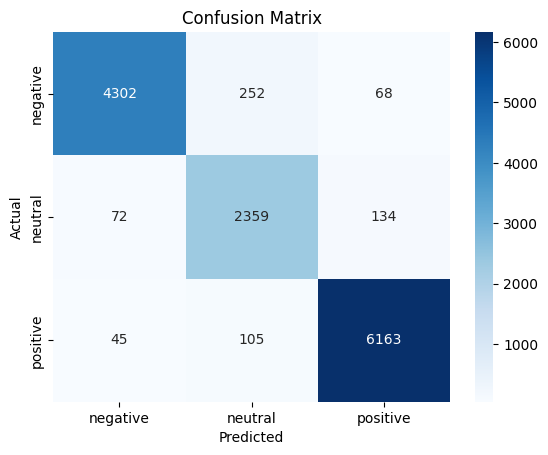

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model Transformer

In [76]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def build_transformer_model(vocab_size, max_len, num_heads=2, ff_dim=128):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attention)

    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(128)(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + x_ff)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vocab_size = len(tokenizer.word_index) + 1

model = build_transformer_model(vocab_size, max_len)
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 100, 128)       │      5,308,160 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 100, 128)       │         66,048 │ embedding_3[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 100, 128)       │              0 │ embedding_3[0][0],     │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 100, 128)       │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 100, 128)       │         16,512 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 100, 128)       │         16,512 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 100, 128)       │              0 │ layer_normalization_2… │
│                           │                        │                │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 100, 128)       │            256 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ layer_normalization_3… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │          8,256 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 3)              │            195 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,416,195 (20.66 MB)

 Trainable params: 5,416,195 (20.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.3667 - loss: 1.1580 - val_accuracy: 0.3143 - val_loss: 1.0893
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4561 - loss: 1.0153 - val_accuracy: 0.4000 - val_loss: 1.0127
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5649 - loss: 0.8794 - val_accuracy: 0.8885 - val_loss: 0.3098
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9084 - loss: 0.2821 - val_accuracy: 0.9353 - val_loss: 0.1903
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9541 - loss: 0.1581 - val_accuracy: 0.9523 - val_loss: 0.1425
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9726 - loss: 0.0987 - val_accuracy: 0.9631 - val_loss: 0.1197
Epoch 7/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9827 - loss: 0.0695 - val_accuracy: 0.9630 - val_loss: 0.1216
Epoch 8/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9887 - loss: 0.0518 - val_acc

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

    negative       0.97      0.97      0.97      4622
     neutral       0.92      0.93      0.92      2565
    positive       0.98      0.98      0.98      6313

    accuracy                           0.97     13500
   macro avg       0.96      0.96      0.96     13500
weighted avg       0.97      0.97      0.97     13500



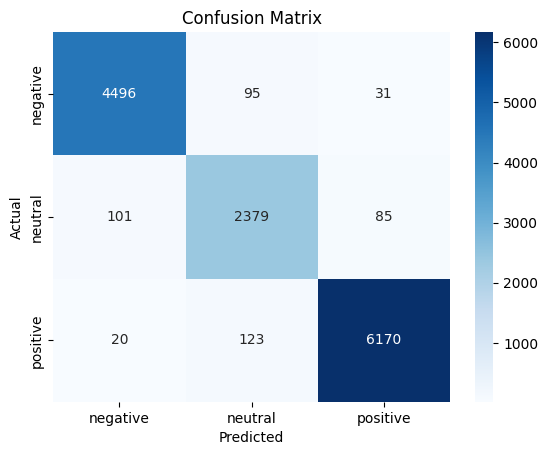

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Ligth GBM

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Menggunakan TF-IDF untuk mengubah teks menjadi fitur numerik
tfidf = TfidfVectorizer(max_features=10000)  # Atau sesuaikan jumlah fitur
X_tfidf = tfidf.fit_transform(clean_df['text_akhir']).toarray()

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,  # Ganti dengan X_word2vec jika menggunakan Word2Vec
    clean_df['polarity'],
    test_size=0.2,
    random_state=42,
    stratify=clean_df['polarity']
)

In [80]:
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
y_test = np.array(le.fit_transform(y_test))

In [81]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import log_evaluation, early_stopping

# Membuat dataset dalam format LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Hyperparameters untuk LightGBM
params = {
    'objective': 'multiclass',  # Untuk masalah klasifikasi multiclass
    'num_class': 3,  # Jumlah kelas (negative, neutral, positive)
    'metric': 'multi_logloss',  # Loss function
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Hyperparameter untuk kontrol overfitting
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9,  # Fraction of features untuk setiap iterasi
}

callbacks = [
    log_evaluation(period=50),  # Log evaluasi setiap 50 iterasi
    early_stopping(stopping_rounds=50)  # Hentikan jika tidak ada perbaikan selama 50 iterasi
]

# Melatih model
clf = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000, callbacks=callbacks)

# Prediksi pada data training
y_train_pred = clf.predict(X_train, num_iteration=clf.best_iteration)
y_train_pred_class = [np.argmax(x) for x in y_train_pred]  # Mengambil kelas dengan probabilitas tertinggi

# Evaluasi akurasi pada data training
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_class)}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred_class, target_names=["negative", "neutral", "positive"]))

# Prediksi dengan model yang dilatih
y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
y_pred_class = [np.argmax(x) for x in y_pred]  # Mengambil kelas dengan probabilitas tertinggi

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class, target_names=["negative", "neutral", "positive"]))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.481959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87356
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 1914
[LightGBM] [Info] Start training from score -1.071889
[LightGBM] [Info] Start training from score -1.660804
[LightGBM] [Info] Start training from score -0.760029
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.520219
[100]	valid_0's multi_logloss: 0.43179
[150]	valid_0's multi_logloss: 0.38741
[200]	valid_0's multi_logloss: 0.359197
[250]	valid_0's multi_logloss: 0.338278
[300]	valid_0's multi_logloss: 0.32183
[350]	valid_0's multi_logloss: 0.308239
[400]	valid_0's multi_logloss: 0.297191
[450]	valid_0's multi_logloss: 0.287542
[500]	valid_0's multi_logloss: 0.2795
[550]	valid_0's multi_logloss: 0.272457
[600]	valid_0's multi_logloss: 0.266368
[650]	valid